# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Baselines

* This notebook evaluates standard classifiers from scikit-learn on the provided features.
* Moreover, it evaluates Deep Learning models on both audio and spectrograms.

In [1]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.models import Model
from keras.layers import  Flatten, Reshape, MaxPooling2D, concatenate
from keras.layers import Input,AveragePooling2D,Activation, Dense, Conv1D, Conv2D, MaxPooling1D

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

import utils

In [2]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')

tracks = utils.load('data/fma_metadata/tracks.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

((106574, 52), (106574, 518), (13129, 249))

## Subset

In [3]:
subset = tracks.index[tracks['set', 'subset'] <= 'medium']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((25000, 52), (25000, 518))

In [4]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

19922 training examples, 2505 validation examples, 2573 testing examples
Top genres (16): ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']
All genres (151): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 37, 38, 41, 42, 43, 45, 46, 47, 49, 53, 58, 63, 64, 65, 66, 70, 71, 74, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 97, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 137, 138, 166, 167, 169, 171, 172, 174, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 311, 314, 322, 337, 359, 360, 361, 362, 374, 378, 400, 401, 404, 428, 439, 440, 441, 442, 443, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 651, 659, 695, 741, 763, 808, 810, 811, 906, 1032, 1060, 1193, 1235]


## 1 Multiple classifiers and feature sets

Todo:
* Cross-validation for hyper-parameters.
* Dimensionality reduction?

### 1.1 Pre-processing

In [5]:
def pre_process(tracks, features, columns, multi_label=False, verbose=False):
    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
        #y = enc.fit_transform(tracks['track', 'genre_top'])
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']
        #labels = tracks['track', 'genres']

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    X_train = features.loc[train, columns].values
    X_val = features.loc[val, columns].values
    X_test = features.loc[test, columns].values
    
    print(len(y_train[0]))
    
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)
    
    return y_train, y_val, y_test, X_train, X_val, X_test

### 1.2 Single genre

In [6]:
"""def test_classifiers_features(classifiers, feature_sets, multi_label=False):
    columns = list(classifiers.keys()).insert(0, 'dim')
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())
    for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):
        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():  # tqdm_notebook(classifiers.items(), desc='classifiers', leave=False):
            t = time.process_time()
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            scores.loc[fset_name, clf_name] = score
            times.loc[fset_name, clf_name] = time.process_time() - t
    return scores, times

def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])"""

"def test_classifiers_features(classifiers, feature_sets, multi_label=False):\n    columns = list(classifiers.keys()).insert(0, 'dim')\n    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())\n    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())\n    for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):\n        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)\n        scores.loc[fset_name, 'dim'] = X_train.shape[1]\n        for clf_name, clf in classifiers.items():  # tqdm_notebook(classifiers.items(), desc='classifiers', leave=False):\n            t = time.process_time()\n            clf.fit(X_train, y_train)\n            score = clf.score(X_test, y_test)\n            scores.loc[fset_name, clf_name] = score\n            times.loc[fset_name, clf_name] = time.process_time() - t\n    return scores, times\n\ndef format_scores(scores):\n    def highlight(s):\n        is_max

In [7]:
"""classifiers = {
    'LR': LogisticRegression(),
    'kNN': KNeighborsClassifier(n_neighbors=200),
    'SVCrbf': SVC(kernel='rbf'),
    'SVCpoly1': SVC(kernel='poly', degree=1),
    'linSVC1': SVC(kernel="linear"),
    'linSVC2': LinearSVC(),
    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    'DT': DecisionTreeClassifier(max_depth=5),
    'RF': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'AdaBoost': AdaBoostClassifier(n_estimators=10),
    'MLP1': MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),
    'MLP2': MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),
    'NB': GaussianNB(),
    'QDA': QuadraticDiscriminantAnalysis(),
}

feature_sets = {
#    'echonest_audio': ('echonest', 'audio_features'),
#    'echonest_social': ('echonest', 'social_features'),
#    'echonest_temporal': ('echonest', 'temporal_features'),
#    'echonest_audio/social': ('echonest', ('audio_features', 'social_features')),
#    'echonest_all': ('echonest', ('audio_features', 'social_features', 'temporal_features')),
}
for name in features.columns.levels[0]:
    feature_sets[name] = name
feature_sets.update({
    'mfcc/contrast': ['mfcc', 'spectral_contrast'],
    'mfcc/contrast/chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
    'mfcc/contrast/centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
    'all_non-echonest': list(features.columns.levels[0])
})

scores, times = test_classifiers_features(classifiers, feature_sets)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))"""

'classifiers = {\n    \'LR\': LogisticRegression(),\n    \'kNN\': KNeighborsClassifier(n_neighbors=200),\n    \'SVCrbf\': SVC(kernel=\'rbf\'),\n    \'SVCpoly1\': SVC(kernel=\'poly\', degree=1),\n    \'linSVC1\': SVC(kernel="linear"),\n    \'linSVC2\': LinearSVC(),\n    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),\n    \'DT\': DecisionTreeClassifier(max_depth=5),\n    \'RF\': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),\n    \'AdaBoost\': AdaBoostClassifier(n_estimators=10),\n    \'MLP1\': MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),\n    \'MLP2\': MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),\n    \'NB\': GaussianNB(),\n    \'QDA\': QuadraticDiscriminantAnalysis(),\n}\n\nfeature_sets = {\n#    \'echonest_audio\': (\'echonest\', \'audio_features\'),\n#    \'echonest_social\': (\'echonest\', \'social_features\'),\n#    \'echonest_temporal\': (\'echonest\', \'temporal_features\'),\n#    \'echonest_audio/social\': (\'echone

### 1.3 Multiple genres

Todo:
* Ignore rare genres? Count them higher up in the genre tree? On the other hand it's not much tracks.

In [8]:
"""classifiers = {
    #LogisticRegression(),
    'LR': OneVsRestClassifier(LogisticRegression()),
    'SVC': OneVsRestClassifier(SVC()),
    'MLP': MLPClassifier(max_iter=700),
}

feature_sets = {
#    'echonest_audio': ('echonest', 'audio_features'),
#    'echonest_temporal': ('echonest', 'temporal_features'),
    'mfcc': 'mfcc',
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
}

scores, times = test_classifiers_features(classifiers, feature_sets, multi_label=True)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))"""

"classifiers = {\n    #LogisticRegression(),\n    'LR': OneVsRestClassifier(LogisticRegression()),\n    'SVC': OneVsRestClassifier(SVC()),\n    'MLP': MLPClassifier(max_iter=700),\n}\n\nfeature_sets = {\n#    'echonest_audio': ('echonest', 'audio_features'),\n#    'echonest_temporal': ('echonest', 'temporal_features'),\n    'mfcc': 'mfcc',\n    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],\n    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],\n}\n\nscores, times = test_classifiers_features(classifiers, feature_sets, multi_label=True)\n\nipd.display(format_scores(scores))\nipd.display(times.style.format('{:.4f}'))"

## 2 Deep learning on raw audio

Other architectures:
* [Learning Features of Music from Scratch (MusicNet)](https://arxiv.org/abs/1611.09827), John Thickstun, Zaid Harchaoui, Sham Kakade.

In [9]:
labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

Load audio samples in parallel using `multiprocessing` so as to maximize CPU usage when decoding MP3s and making some optional pre-processing. There are multiple ways to load a waveform from a compressed MP3:
* librosa uses audioread in the backend which can use many native libraries, e.g. ffmpeg
    * resampling is very slow --> use `kaiser_fast`
    * does not work with multi-processing, for keras `fit_generator()`
* pydub is a high-level interface for audio modification, uses ffmpeg to load
    * store a temporary `.wav`
* directly pipe ffmpeg output
    * fastest method
* [pyAV](https://github.com/mikeboers/PyAV) may be a fastest alternative by linking to ffmpeg libraries

In [10]:
# Just be sure that everything is fine. Multiprocessing is tricky to debug.
utils.FfmpegLoader().load(utils.get_audio_path(AUDIO_DIR, 2))
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, utils.FfmpegLoader())
SampleLoader(train, batch_size=2).__next__()[0].shape


Ignoring ./data/fma_small/129/129354.mp3 (error: Command '['ffmpeg', '-i', './data/fma_small/129/129354.mp3', '-f', 's16le', '-acodec', 'pcm_s16le', '-ac', '1', '-']' returned non-zero exit status 1.).


(1, 1321967)

In [11]:
# Keras parameters.
NB_WORKER = len(os.sched_getaffinity(0))  # number of usables CPUs
params = {'pickle_safe': True, 'nb_worker': NB_WORKER, 'max_q_size': 10}

### 2.1 Fully connected neural network

* Two layers with 10 hiddens is no better than random, ~11%.

Optimize data loading to be CPU / GPU bound, not IO bound. Larger batches means reduced training time, so increase batch time until memory exhaustion. Number of workers and queue size have no influence on speed.

In [12]:
'''
loader = utils.FfmpegLoader(sampling_rate=2000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
print('Dimensionality: {}'.format(loader.shape))

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(output_dim=1000, input_shape=loader.shape))
model.add(Activation("relu"))
model.add(Dense(output_dim=100))
model.add(Activation("relu"))
model.add(Dense(output_dim=labels_onehot.shape[1]))
model.add(Activation("softmax"))

optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=64), train.size, nb_epoch=2, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=64), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=64), test.size, **params)
#Y = model.predict_generator(SampleLoader(test, batch_size=64), test.size, **params);

loss
'''

Dimensionality: (59953,)


TypeError: __init__() missing 1 required positional argument: 'units'

### 2.2 Convolutional neural network

* Architecture: [End-to-end learning for music audio](http://www.mirlab.org/conference_papers/International_Conference/ICASSP%202014/papers/p7014-dieleman.pdf), Sander Dieleman, Benjamin Schrauwen.
* Missing: track segmentation and class averaging (majority voting)
* Compared with log-scaled mel-spectrograms instead of strided convolution as first layer.
* Larger net: http://benanne.github.io/2014/08/05/spotify-cnns.html

In [ ]:
'''
loader = utils.FfmpegLoader(sampling_rate=16000)
#loader = utils.LibrosaLoader(sampling_rate=16000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)

keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((-1, 1), input_shape=loader.shape))
print(model.output_shape)

model.add(Conv1D(128, 512, subsample_length=512))
print(model.output_shape)
model.add(Activation("relu"))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

model.add(Conv1D(32, 8))
print(model.output_shape)
model.add(Activation("relu"))
model.add(MaxPooling1D(4))

print(model.output_shape)
#model.add(Dropout(0.25))
model.add(Flatten())
print(model.output_shape)
model.add(Dense(100))
model.add(Activation("relu"))
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#, momentum=0.9, nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=10), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=10), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=10), test.size, **params)

loss
'''

### 2.3 Our network (nnet1) from paper

In [18]:

loader = utils.FfmpegLoader(sampling_rate=16000)
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)

keras.backend.clear_session()



input_shape=[128,513,1]
inputs = Input(shape=input_shape)

conv1=Conv2D(kernel_size=(4,513),filters=128,activation="relu")(inputs)
pool1=MaxPooling2D( pool_size=(2, 1))(conv1)
conv2=Conv2D(kernel_size=(4,1),filters=128,activation="relu")(pool1)
pool2=MaxPooling2D( pool_size=(2, 1))(conv2)
conv3=Conv2D(kernel_size=(4,1),filters=256,activation="relu")(pool2)
# Average pooling layer
average_pool = AveragePooling2D(pool_size=(26,1))(conv3)
# Max pooling layer
max_pool = MaxPooling2D(pool_size=(26,1))(conv3)

# Concatenate the average pooling and max pooling outputs
merged = concatenate([average_pool, max_pool], axis=2)

# Flatten the output for the fully connected layers
flatten = Flatten()(merged)

# Dense layers
dense1 = Dense(300, activation='relu')(flatten)
dense2 = Dense(150, activation='relu')(dense1)
dense3 = Dense(10, activation='softmax')(dense2)

model = Model(inputs=inputs, outputs=dense3)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 513, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 1, 128)  262784      input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 1, 128)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 1, 128)   65664       max_pooling2d[0][0]              
______________________________________________________________________________________________

### 2.4 creating the STFT training set

#### 2.4.1 Let's try with just one spectrogram

In [168]:
import librosa
import librosa.display
import utils
import os
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

AUDIO_DIR = os.environ.get('AUDIO_DIR')

#1 extract all track_id for fma_small + the label top_genre (by using track.csv) using only the train subset
#2 open the track with utils.get_audio_path(AUDIO_DIR, track_id).
#3 divide in 3s clips with 50% overlapping
#3 for each clip compute the stft using a frame of length 1024
#  with overlap of 50% (a hop of length 512) (and save in a file named with the track_id)


#first lets try to do an example with just one song
filename = utils.get_audio_path(AUDIO_DIR, 704)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True) #load the MONO instead of stereo as in paper
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))
print("**duration:",x.shape[-1]/sr)
print('Original sample rate: ',librosa.get_samplerate(filename))

#resample from 44100 to 22050 as in the paper
target_sr = sr//1 #leave 44100 for now
x = librosa.resample(x,orig_sr=sr, target_sr=target_sr)
print('New sample rate: ',target_sr)

#create a clip of the song
start, end = 7, 10
clip = x[start*sr:end*sr]
print('Duration in seconds of the clip:',(end-start))
print('Number of samples of the clip:',len(clip))


#calculate stft on the clip
stft = np.abs(librosa.stft(clip, n_fft=1024, hop_length=512))
print("Shape of the stft:",stft.shape)
#resize the spectrogram to become 512 x 128 instead of 512 x 130
stft = librosa.util.fix_length(stft, size=513, axis=0)[:, :128]

print("Shape of the resized stft:",stft.shape)
ipd.Audio(data=x_rs[start*target_sr:end*target_sr], rate=target_sr)

File: ./data/fma_small/000/000704.mp3
Duration: 29.98s, 1321967 samples
**duration: 29.976575963718822
Original sample rate:  44100
New sample rate:  44100
Duration in seconds of the clip: 3
Number of samples of the clip: 132300
Shape of the stft: (513, 259)
Shape of the resized stft: (513, 128)


#### 2.4.2 Let's try to get all the spectrograms for each 3s clip

start: 0  end: 3
start: 3  end: 6
start: 6  end: 9
start: 9  end: 12
start: 12  end: 15
start: 15  end: 18
start: 18  end: 21
start: 21  end: 24
start: 24  end: 27
start: 27  end: 30
shape of the stft vector:  (10, 513, 128)


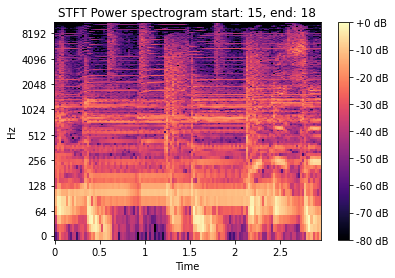

In [189]:
#now lets try to calculate stft on each 3s clip of the 30s song

stft_list = []

for i in range (0,28,3):
    start, end = i, i+3
    print('start:',start,' end:',end)
    
    #extract clip (TODO: IMPLEMENT 50% OVERLAPPING TO GET THE DOUBLE OF THE CLIPS)
    clip = x[start*sr:end*sr]
    
    #calculate stft
    stft = np.abs(librosa.stft(clip, n_fft=1024, hop_length=512))
    #print("Shape of the stft:",stft.shape)

    #resize the spectrogram to become 512 x 128 instead of 512 x 130
    stft = librosa.util.fix_length(stft, size=513, axis=0)[:, :128]
    #print("Shape of the resized stft:",stft.shape)
    
    stft_list.append(stft)
    
stft_array = np.array(stft_list)
print("shape of the stft vector: ", stft_array.shape)

fig, ax = plt.subplots()
clip_number = 5 #a number from 0 to 9
img = librosa.display.specshow(librosa.amplitude_to_db(stft_array[clip_number], ref=np.max), y_axis='log', x_axis='time', ax=ax)
ax.set_title('STFT Power spectrogram start: {}, end: {}'.format(3*clip_number,3*clip_number+3))
fig.colorbar(img, ax=ax, format="%+2.0f dB")

#### Let's try to get all the spectrograms for all the audio in the dataset

In [ ]:
#TODO: 
#1-get all the track ids for the small subset
#2-load each file
#3-compute its stft vector
#4-save the final training set in a vector

## 3 Deep learning on extracted audio features

Look at:
* Pre-processing in Keras: https://github.com/keunwoochoi/kapre
* Convolutional Recurrent Neural Networks for Music Classification: https://github.com/keunwoochoi/icassp_2017
* Music Auto-Tagger: https://github.com/keunwoochoi/music-auto_tagging-keras
* Pre-processor: https://github.com/bmcfee/pumpp

### 3.1 ConvNet on MFCC

* Architecture: [Automatic Musical Pattern Feature Extraction Using Convolutional Neural Network](http://www.iaeng.org/publication/IMECS2010/IMECS2010_pp546-550.pdf), Tom LH. Li, Antoni B. Chan and Andy HW. Chun
* Missing: track segmentation and majority voting.
* Best seen: 17.6%

In [ ]:
class MfccLoader(utils.Loader):
    raw_loader = utils.FfmpegLoader(sampling_rate=22050)
    #shape = (13, 190)  # For segmented tracks.
    shape = (13, 2582)
    def load(self, filename):
        import librosa
        x = self.raw_loader.load(filename)
        # Each MFCC frame spans 23ms on the audio signal with 50% overlap with the adjacent frames.
        mfcc = librosa.feature.mfcc(x, sr=22050, n_mfcc=13, n_fft=512, hop_length=256)
        return mfcc

loader = MfccLoader()
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)
loader.load(utils.get_audio_path(AUDIO_DIR, 2))[0].shape

In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((*loader.shape, 1),  input_shape=loader.shape))
print(model.output_shape)

model.add(Conv2D(3, 13, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Conv2D(15, 1, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Conv2D(65, 1, 10, subsample=(1, 4)))
model.add(Activation("relu"))
print(model.output_shape)

model.add(Flatten())
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(1e-3)#lr=0.01, momentum=0.9, nesterov=True)
#optimizer = keras.optimizers.Adam()#lr=1e-5)#
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=16), train.size, nb_epoch=20, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=16), val.size, **params)
loss = model.evaluate_generator(SampleLoader(test, batch_size=16), test.size, **params)
#Y = model.predict_generator(loader, test.size, pickle_safe=True, nb_worker=NB_WORKER, max_q_size=5)

loss